# Apache Kafka Streaming Analytics
### One Broker Setup
<br>
<hr>

#### Component: Consumer
In this notebook Apache Kafka is going to be used and analyzed with reference to the streaming performance using the twitter dataset.

In this case, we are going to use only one **Kafka Broker** that streams the data to the **Kafka Consumer**.

In [ ]:
# Install the Python Client for Apache Kafka
!pip install confluent-kafka

In [2]:
# Load dependencies and set constants
import matplotlib.pyplot as plt
import json
import time

from confluent_kafka import Consumer, KafkaError

CONSUMER_GROUP_ID = "twitter-consumers"
KAFKA_TOPIC_TWITTER = "twitter-stream"


def get_kafka_stats(json_stats_bytes):
    """ Callback for the Apache Kafka Consumer Configuration which 
    requests performance metrics / statistics from Kafka. 
    
    :param json_stats_bytes: The JSON statistics data in bytes
    """
    # Decode the bytes into a python dictionary representing the JSON
    stats = json.loads(json_stats_bytes)
    # TODO: Check if we can actually use those statistics. If so, uncomment them in the consumer config

### Reminder: Running Kafka Architecture required
The following cells assume a running Apache Kafka Environment.
<hr>
<br>

Furthermore, as we are using the **Consumer** component here, we have to make sure to start the consumer first before we start the Producer to ensure a performance measurement under realistic circumstances.

In [23]:
# Consume the data
consumer_config = {
    "bootstrap.servers": "localhost:9092",
    "group.id": CONSUMER_GROUP_ID,
    "client.id": "client-1",
#     "stats_cb": get_kafka_stats,
#     "statistics.interval.ms": 20,
#     'api.version.request': True,
    "enable.auto.commit": True,
    "session.timeout.ms": 6000,
    "default.topic.config": {"auto.offset.reset": "smallest"}
}
c = Consumer(consumer_config)

In [24]:
c.subscribe([KAFKA_TOPIC_TWITTER])

msg_count = 0
latency_sum = 0
latencies = []
try:
    while True:
            msg = c.poll(0)
            
            if msg is None:
                continue
            elif not msg.error():
                msg_count += 1
                timestamp_type, timestamp = msg.timestamp()
                latency = (time.time() * 1000) - timestamp
                
                latency_sum += latency
                latencies.append(latency)
                
                # Display the received tweet
                #tweet_json = json.loads(msg.value())
                #print(json.dumps(tweet_json, indent=4, ensure_ascii=False, sort_keys=True))
            elif msg.error().code() == KafkaError._PARTITION_EOF:
                print("End of partition reached {}/{}".format(msg.topic(), msg.partition()))
            else:
                print("Error occured: {}".format(msg.error().str()))
except KeyBoardInterrupt:
    pass
finally:
    print("Received {} messages".format(msg_count))
    print("Average latency: {}".format(latency_sum / msg_count))
    c.close()

Received 144850 messages
Average latency: 31.236429212871073


NameError: name 'KeyBoardInterrupt' is not defined

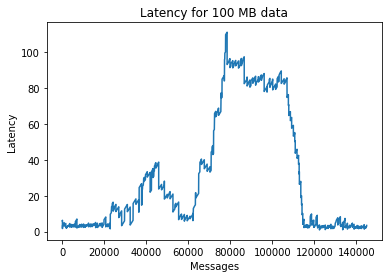

In [25]:
# Plot latency results
fig = plt.figure()
ax = plt.axes()

xs = [i for i in range(msg_count)]
ys = latencies

ax.plot(xs, ys)
ax.set_xlabel("Messages")
ax.set_ylabel("Latency")
ax.set_title("Latency for 100 MB data")
fig.show()